# Imports

In [1]:
import numpy as np
import pandas as pd

# Text Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
import re

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, Embedding, Activation, TextVectorization, Concatenate, SimpleRNN, Conv1D, GlobalMaxPooling1D
from attention import Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN
import keras
import keras_tuner
from tensorflow.random import set_seed

# Metrics
from sklearn.metrics import classification_report, roc_curve, confusion_matrix,  auc

# Traning helper functions
from sklearn.model_selection import train_test_split

# Utility Functions
import pickle
import shutil
from tqdm.auto import tqdm # Showing progress bar
tqdm.pandas()

import os

c:\Users\User\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data')
# import data
imdb_df = pd.read_csv(os.path.join(data_path, 'IMDB Dataset.csv'))

# EDA

In [47]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


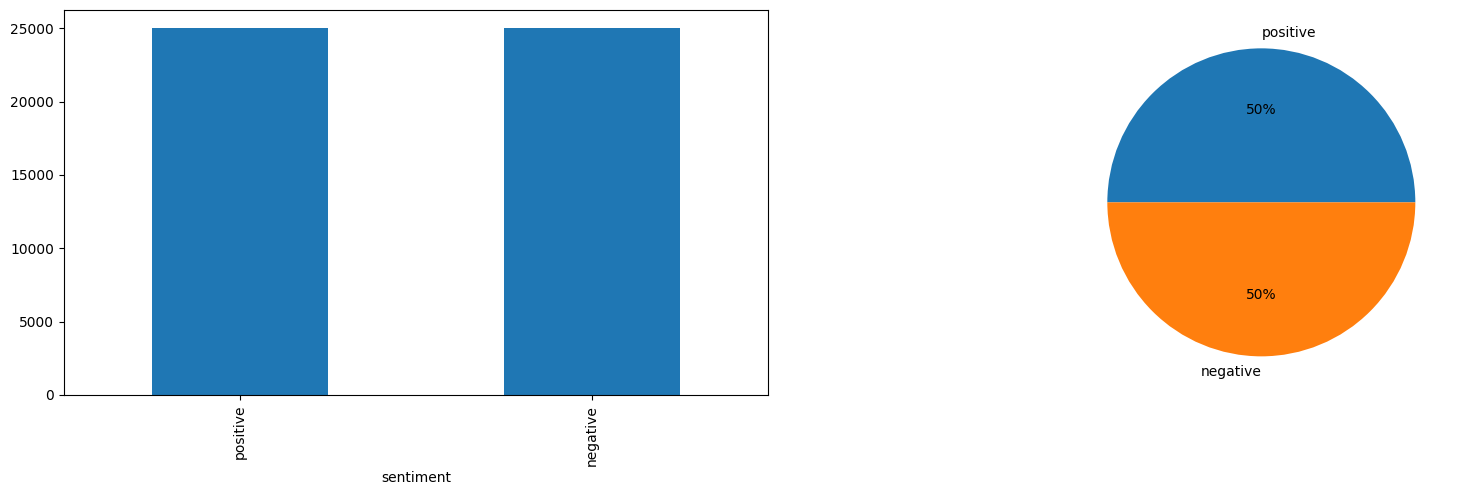

In [62]:
label_info = imdb_df['sentiment'].value_counts()
print(label_info)
plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.0f%%')

plt.show()

# Text-Preproccessing

## Text Cleaning Utility Function

In [49]:
def clean_text(text):
  # Apostrophe
  text = re.sub(r'\x89Ûª', "'", text)
  text = re.sub(r'\x89Û÷', "'", text)

  # Quotation
  text = re.sub(r'\x89ÛÏ', '"', text)
  text = re.sub(r'\x89Û\x9d', '"', text)

  # Hyphen
  text = re.sub(r'\x89ÛÒ', '-', text)
  text = re.sub(r'\x89ÛÓ', '—', text)

  # Euro
  text = re.sub(r'\x89âÂ', '€', text)

  # Ellipsis
  text = re.sub(r'\x89Û_', '...', text)

  # Ampersand
  text = re.sub(r'&', 'and', text)

  # Bullet
  text = re.sub(r"\x89Û¢åÊ", "", text)
  text = re.sub(r'\x89Û¢', '', text)

  # Wrong encodings
  text = re.sub(r"fromåÊwounds", "from wounds", text)
  text = re.sub(r"åÊ", "", text)
  text = re.sub(r"åÈ", "", text)
  text = re.sub(r"JapÌ_n", "Japan", text)
  text = re.sub(r"Ì©", "e", text)
  text = re.sub(r"å¨", "", text)
  text = re.sub(r"SuruÌ¤", "Suruc", text)
  text = re.sub(r"åÇ", "", text)
  text = re.sub(r"å£3million", "3 million ", text)
  text = re.sub(r"åÀ", "", text)

  return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Creating Corpus

### Stop Word Removal
Removing common words that don't provide much semantic meanings

In [50]:
imdb_cleaned = imdb_df.copy()
stop_words = stopwords.words('english')
imdb_cleaned['sentiment'] = imdb_cleaned['sentiment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

- The texts will be lowercased
- Short forms will be converted to the right word
- Punctuations will be removed
- The words are stemmed

reference : https://www.kaggle.com/code/quentinsarrazin/tweets-preprocessing/notebook

In [51]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "la" : "los angeles",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [52]:
def to_lower(text):
    return text.lower()

def remove_punc(text):
    return re.sub(r"[^\w\s]","", text)

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in word_tokenize(text):
        string += word_abbrev(word) + " "        
    return string

def remove_stop_word(text: str):
    stop_words = stopwords.words("english")
    return " ".join(
        [word for word in word_tokenize(text) if word not in (stop_words)]
    )

stemmer = SnowballStemmer("english")
def stem(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

In [53]:
def preprocess_text(input_data):
    r = clean_text(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = to_lower(r)
    r = remove_punc(r)
    r = replace_abbrev(r)
    r = remove_stop_word(r)
    r = stem(r)
    return r

In [54]:
imdb_cleaned['review'] = imdb_cleaned['review'].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 50000/50000 [01:38<00:00, 508.06it/s]


In [55]:
imdb_cleaned.head()

,review,sentiment
0,one of the other review has mention that after...,positive
1,a wonder littl production. the film techniqu i...,positive
2,i thought this was a wonder way to spend time ...,positive
3,basic there a famili where a littl boy (jake) ...,negative
4,"petter mattei ""love in the time of money"" is a...",positive


## Data Cleaning
- Some of the texts maybe completely blank after preprocessing, need to remove those
- Also removing texts that are shorter than 40 characters which may not provide much information

In [56]:
imdb_cleaned.isnull().sum()

review       0
sentiment    0
dtype: int64

In [21]:
imdb_filtered = imdb_cleaned[imdb_cleaned["review"].str.len() > 40]
imdb_filtered.head()

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1


In [17]:
# remove duplicates
imdb_cleaned.drop_duplicates(inplace=True)
imdb_cleaned.reset_index(drop=True, inplace=True)
imdb_cleaned

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1
...,...,...
49575,i thought this movi did a down right good job....,1
49576,"bad plot, bad dialogue, bad acting, idiot dire...",0
49577,i am a cathol taught in parochi elementari sch...,0
49578,i'm go to have to disagre with the previous co...,0


49580
sentiment
1    24884
0    24696
Name: count, dtype: int64


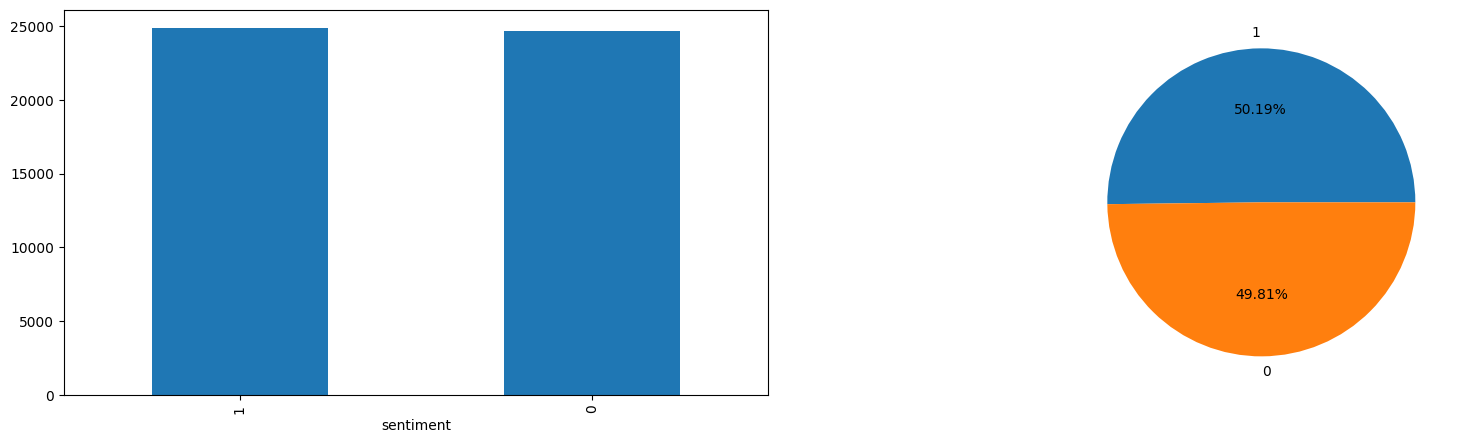

In [26]:
print(len(imdb_filtered))
label_info = imdb_filtered['sentiment'].value_counts()
print(label_info)

plt.figure(figsize=((20,5)))
plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.2f%%')

plt.show()

## Output Clean intermediate data
Saving the preprocessed data produced into a csv file, allowing the cleaned data to be reaccessed quickly and easily.

In [27]:
imdb_filtered.to_csv("./data/cleaned_IMDB_data.csv", index=False)

In [2]:
imdb_filtered = pd.read_csv("./data/cleaned_IMDB_data.csv")
imdb_filtered.head()

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1


# Text Visualization
Visualizes the frequency of the words for each category

## Word Clouds
### Positive Word Cloud

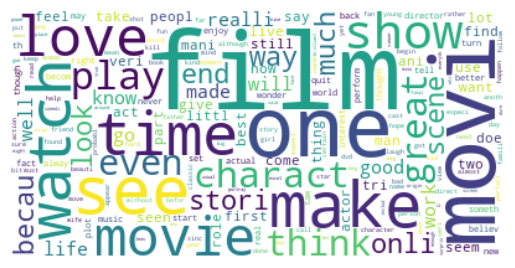

In [104]:
text_positive = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "positive"]["review"])
wordcloud_positive = WordCloud(background_color="white").generate(text_positive)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Word Cloud

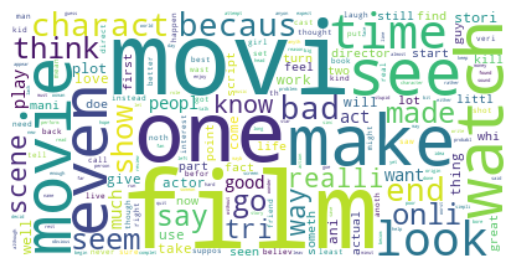

In [105]:
text_negative = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "negative"]["review"])
wordcloud_negative = WordCloud(background_color="white").generate(text_negative)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization
Creating a keras layer that vectorizes the texts into tokens

In [ ]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
vectorize_layers = [
    TextVectorization(
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=max_len)
    for max_feat, max_len in configurations
]

In [7]:
[vectorize_layer.adapt(imdb_filtered['review']) for vectorize_layer in vectorize_layers]

[None, None, None, None]

In [ ]:
# Exporting the vectorize_layer for future use
pickle.dump([{'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights(),
             'vocabs': vectorize_layer.get_vocabulary(),
             'parameter': configurations[i]} for i, vectorize_layer in enumerate(vectorize_layers)]
            , open("./vectorised_model/vectorizers.pkl", "wb"))

In [18]:
# Importing from disk
from_disk = pickle.load(open("./vectorised_model/vectorizers.pkl", "rb"))

vectorize_layers = [TextVectorization.from_config(val['config']) for val in from_disk]

[vectorize_layer.set_weights(from_disk[i]['weights']) for i, vectorize_layer in enumerate(vectorize_layers)]

[None, None, None, None]

# Modelling

In [16]:
#  change positive sentimanet to 1 and negative to 0
imdb_filtered['sentiment'] = imdb_filtered['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
imdb_filtered

,review,sentiment
0,one of the other review has mention that after...,0
1,a wonder littl production. the film techniqu i...,0
2,i thought this was a wonder way to spend time ...,0
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",0
...,...,...
49575,i thought this movi did a down right good job....,0
49576,"bad plot, bad dialogue, bad acting, idiot dire...",0
49577,i am a cathol taught in parochi elementari sch...,0
49578,i'm go to have to disagre with the previous co...,0


## Train Test Split

In [10]:
#  train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_filtered['review'], imdb_filtered['sentiment'], test_size=0.2, random_state=42, stratify=imdb_filtered['sentiment'])

## Helper Functions for Modelling

In [9]:
## This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [11]:
def plot_confusion_matrix(y_test, y_pred):    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [12]:
def plot_roc_auc(y_test, y_pred):
    # plot roc auc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [13]:
lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False, restore_best_weights=True)
tn = TerminateOnNaN()

In [14]:
# custom F1 score metric
@keras.saving.register_keras_serializable()
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred) - tp
    fn = tf.reduce_sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return 2 * precision * recall / (precision + recall)

## Tuning max_features and max_len configurations

In [4]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

## LSTM Model

In [3]:
def create_lstm_tune(units, dropout, lr, embedding_dim, configuration_index):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    if dropout:
        model.add(Dropout(rate=0.5))
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC(name="auc")]
    )
    return model


def tune_lstm(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim
    )
    return model

### Initial Model

In [52]:
initial_lstm_model = create_lstm_tune(units=64, dropout= True, lr=0.005, embedding_dim=128, configuration_index=0)
initial_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          2560128   
                                                                 
 dropout_1 (Dropout)         (None, 500, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2609601 (9.95 MB)
Trainable params: 2609601 (9.95 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [53]:
hist = initial_lstm_model.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20
310/310 [==============================] - 160s 513ms/step - loss: 0.6934 - accuracy: 0.5021 - f1_score: nan - auc: 0.5062 - val_loss: 0.6920 - val_accuracy: 0.5097 - val_f1_score: nan - val_auc: 0.5119 - lr: 0.0050
Epoch 2/20
310/310 [==============================] - 161s 521ms/step - loss: 0.6865 - accuracy: 0.5150 - f1_score: nan - auc: 0.5296 - val_loss: 0.6949 - val_accuracy: 0.5073 - val_f1_score: nan - val_auc: 0.5105 - lr: 0.0050
Epoch 3/20
310/310 [==============================] - 165s 534ms/step - loss: 0.6321 - accuracy: 0.5790 - f1_score: 0.4669 - auc: 0.6394 - val_loss: 0.4332 - val_accuracy: 0.8215 - val_f1_score: 0.8195 - val_auc: 0.8875 - lr: 0.0050
Epoch 4/20
310/310 [==============================] - 164s 530ms/step - loss: 0.3117 - accuracy: 0.8750 - f1_score: 0.8751 - auc: 0.9401 - val_loss: 0.2978 - val_accuracy: 0.8819 - val_f1_score: 0.8799 - val_auc: 0.9468 - lr: 0.0050
Epoch 5/20
310/310 [==============================] - 165s 533ms/step - loss: 0.

#### Model Testing

In [54]:
# Classification Report and Confusion Matrix
y_pred = initial_lstm_model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

310/310 [==============================] - 11s 34ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4939
           1       0.89      0.88      0.89      4977

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



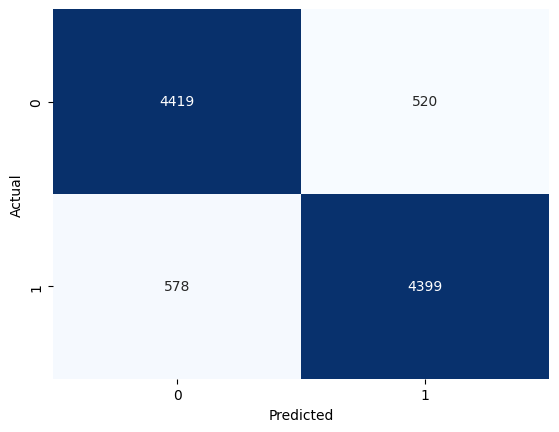

In [55]:
plot_confusion_matrix(y_test, y_pred)

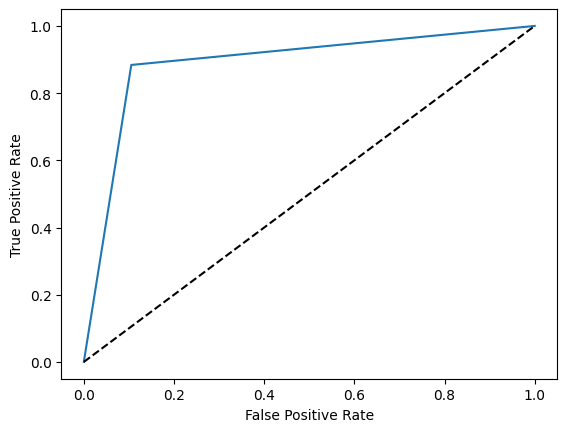

In [56]:
plot_roc_auc(y_test, y_pred)

#### Model history

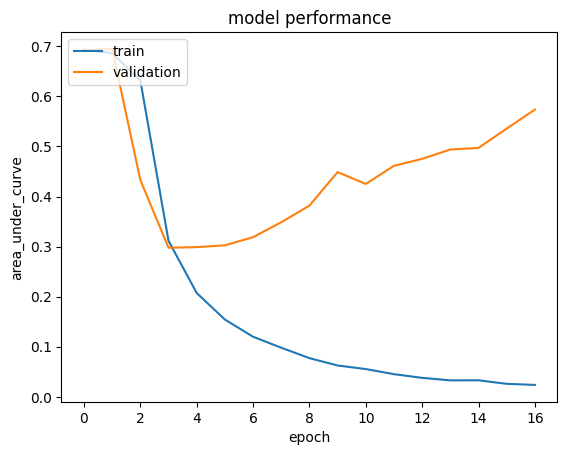

In [57]:
plot_hist(hist, metric='loss')

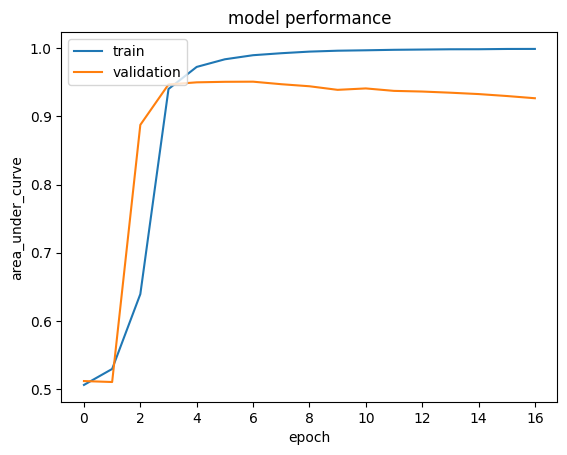

In [58]:
plot_hist(hist)

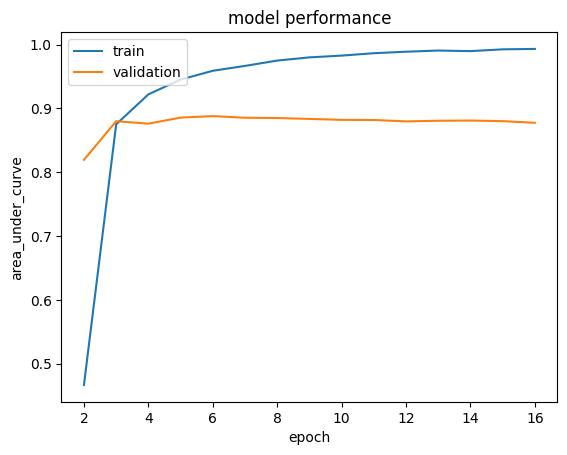

In [59]:
plot_hist(hist, metric='f1_score')

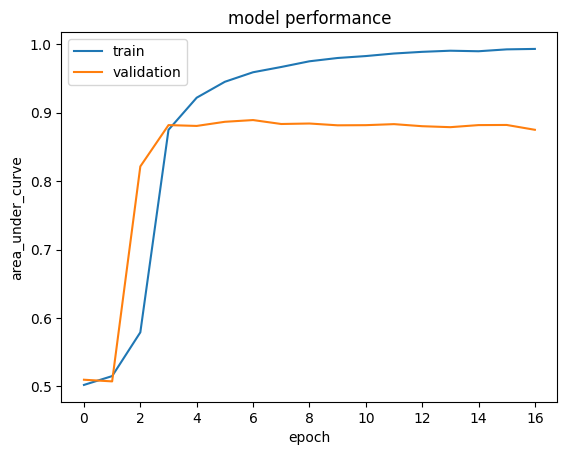

In [60]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [19]:
tuner_lstm = keras_tuner.RandomSearch(
    hypermodel=tune_lstm,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=20,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="lstm",
)

tuner_lstm.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

print(tuner_lstm.get_best_models()[0].summary())

best_hps=tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [01h 00m 48s]
val_auc: 0.560102641582489

Best val_auc So Far: 0.9539313018321991
Total elapsed time: 1d 07h 10m 51s
INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 500)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 500, 256)          2560256   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2757505 (10.52 MB)
Trainable params: 2757505 (10.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### Build Tuned Model

In [20]:
## Training the best model
best_lstm = tuner_lstm.get_best_models()[0]
best_lstm.build(X_train.shape)
hist = best_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

Epoch 1/10
1240/1240 [==============================] - 809s 651ms/step - loss: 0.1576 - accuracy: 0.9431 - f1_score: 0.9416 - auc: 0.9835 - val_loss: 0.2802 - val_accuracy: 0.8930 - val_f1_score: 0.8918 - val_auc: 0.9561 - lr: 0.0019
Epoch 2/10
1240/1240 [==============================] - 455s 367ms/step - loss: 0.1113 - accuracy: 0.9616 - f1_score: 0.9604 - auc: 0.9906 - val_loss: 0.3130 - val_accuracy: 0.8795 - val_f1_score: 0.8691 - val_auc: 0.9542 - lr: 0.0019
Epoch 3/10
1240/1240 [==============================] - 472s 381ms/step - loss: 0.0791 - accuracy: 0.9750 - f1_score: 0.9742 - auc: 0.9944 - val_loss: 0.3541 - val_accuracy: 0.8818 - val_f1_score: 0.8842 - val_auc: 0.9490 - lr: 0.0019
Epoch 4/10
1240/1240 [==============================] - 482s 389ms/step - loss: 0.0562 - accuracy: 0.9832 - f1_score: 0.9827 - auc: 0.9965 - val_loss: 0.3911 - val_accuracy: 0.8846 - val_f1_score: 0.8809 - val_auc: 0.9449 - lr: 0.0019
Epoch 5/10
1240/1240 [==============================] - 474s

##### Tuned Model Testing

In [28]:
# Classification Report and Confusion Matrix
y_pred = best_lstm.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

310/310 [==============================] - 35s 113ms/step
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4939
           1       0.90      0.85      0.88      4977

    accuracy                           0.88      9916
   macro avg       0.88      0.88      0.88      9916
weighted avg       0.88      0.88      0.88      9916



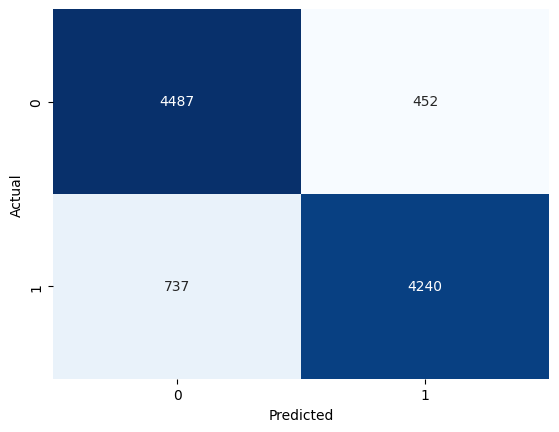

In [30]:
plot_confusion_matrix(y_test, y_pred)

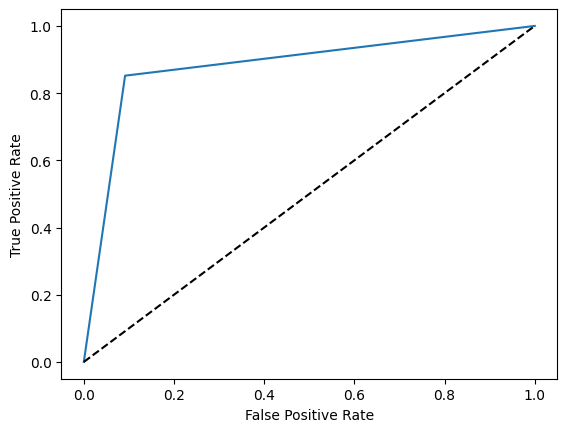

In [29]:
plot_roc_auc(y_test, y_pred)

##### Tuned Model History

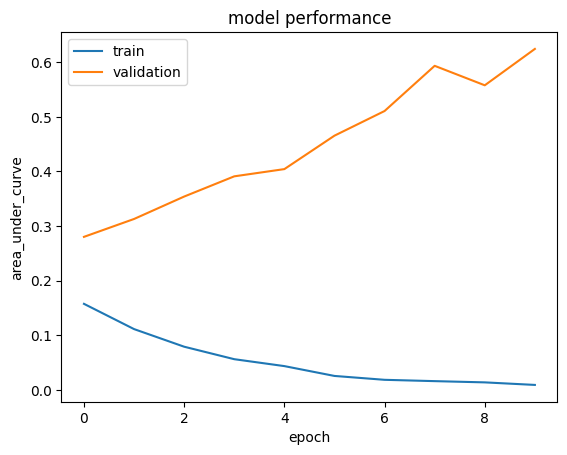

In [31]:
plot_hist(hist, metric='loss')

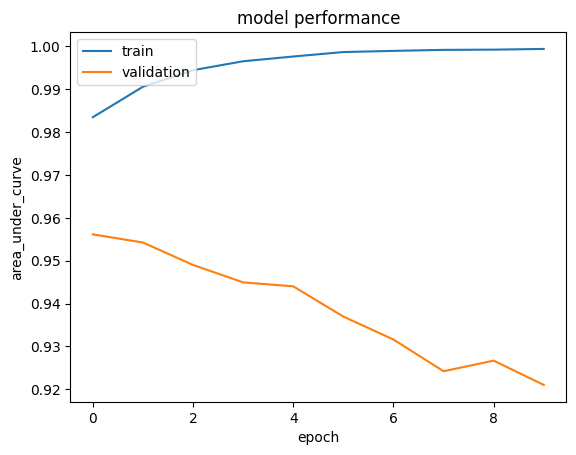

In [32]:
plot_hist(hist)

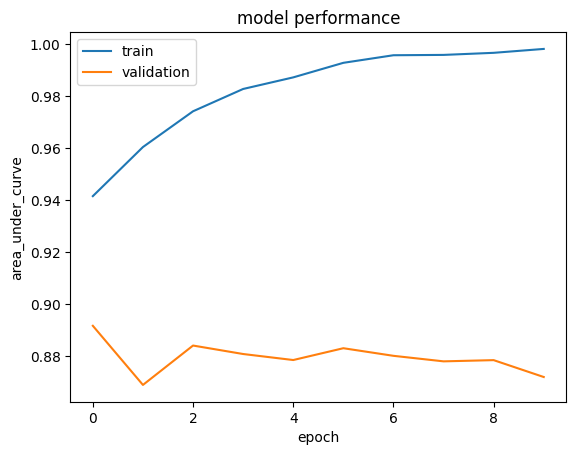

In [33]:
plot_hist(hist, metric='f1_score')

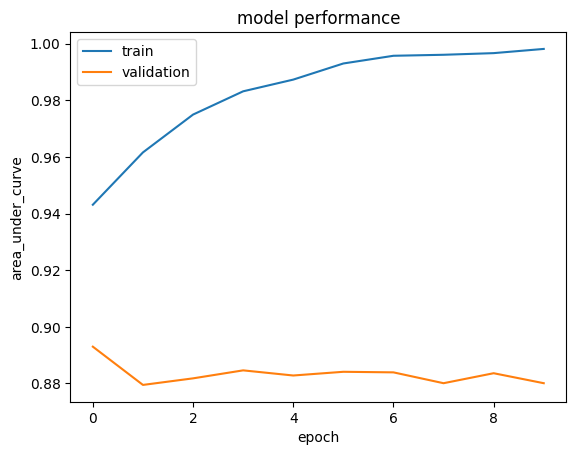

In [34]:
plot_hist(hist, metric='accuracy')

In [36]:
#  save model 
best_lstm.save("./models/best_lstm_model")

INFO:tensorflow:Assets written to: ./models/best_lstm_model\assets


INFO:tensorflow:Assets written to: ./models/best_lstm_model\assets


## CNN-1D Model

### Initial Model

In [19]:
# create CNN model
def create_CNN1D(config_index):
    max_features, _ = configurations[config_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorize_layers[config_index])
    model.add(Embedding(max_features + 1, 128))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [20]:
CNN1D = create_CNN1D(0)

# Compile the model
CNN1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, AUC()])

CNN1D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 conv1d (Conv1D)             (None, 165, 128)          114816    
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           114816    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               1

In [21]:
hist = CNN1D.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20
310/310 [==============================] - 33s 104ms/step - loss: 0.4392 - accuracy: 0.7699 - f1_score: nan - auc: 0.8716 - val_loss: 0.2843 - val_accuracy: 0.8776 - val_f1_score: 0.8731 - val_auc: 0.9530 - lr: 0.0010
Epoch 2/20
310/310 [==============================] - 32s 102ms/step - loss: 0.2000 - accuracy: 0.9239 - f1_score: 0.9236 - auc: 0.9749 - val_loss: 0.2873 - val_accuracy: 0.8838 - val_f1_score: 0.8888 - val_auc: 0.9558 - lr: 0.0010
Epoch 3/20
310/310 [==============================] - 32s 104ms/step - loss: 0.0906 - accuracy: 0.9692 - f1_score: 0.9690 - auc: 0.9938 - val_loss: 0.3611 - val_accuracy: 0.8811 - val_f1_score: 0.8798 - val_auc: 0.9473 - lr: 0.0010
Epoch 4/20
310/310 [==============================] - 32s 104ms/step - loss: 0.0346 - accuracy: 0.9889 - f1_score: 0.9889 - auc: 0.9987 - val_loss: 0.4832 - val_accuracy: 0.8744 - val_f1_score: 0.8695 - val_auc: 0.9391 - lr: 0.0010
Epoch 5/20
310/310 [==============================] - 32s 104ms/step - loss

#### Model Testing

In [23]:
# Classification Report and Confusion Matrix
y_pred = CNN1D.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

310/310 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      4939
           1       0.85      0.93      0.89      4977

    accuracy                           0.88      9916
   macro avg       0.89      0.88      0.88      9916
weighted avg       0.89      0.88      0.88      9916



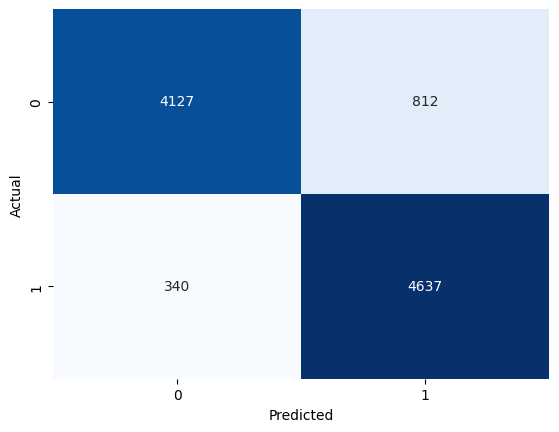

In [26]:
plot_confusion_matrix(y_test, y_pred)

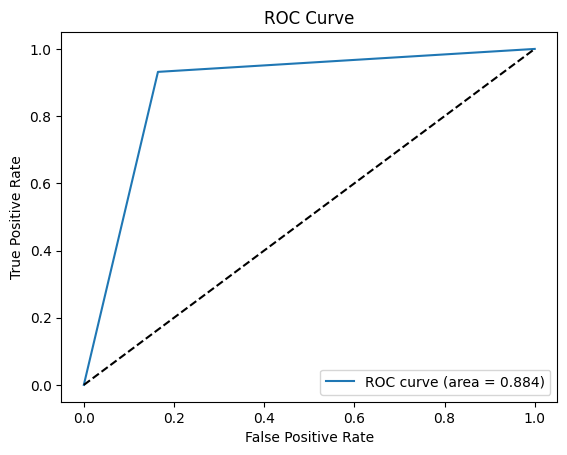

In [31]:
plot_roc_auc(y_test, y_pred)

#### Model History

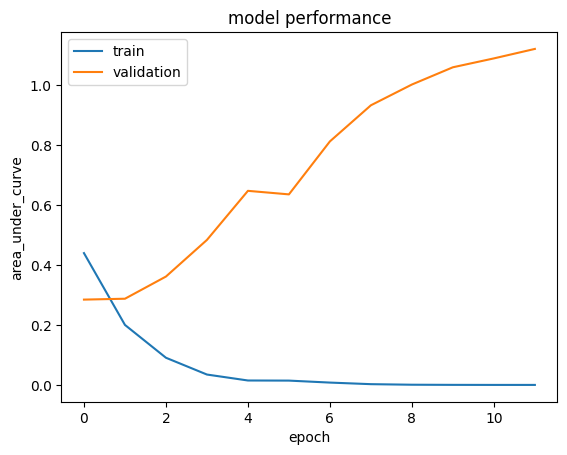

In [32]:
plot_hist(hist, metric='loss')

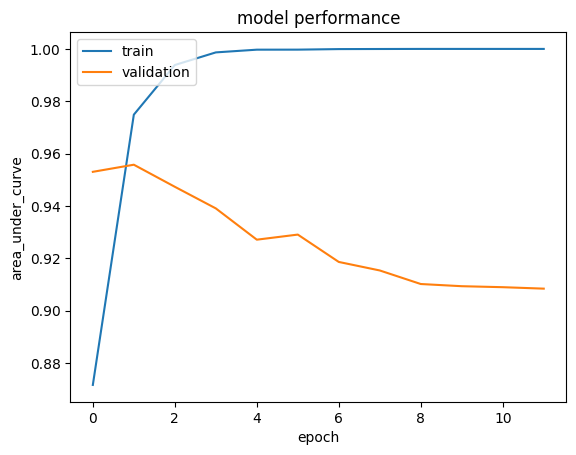

In [22]:
plot_hist(hist)

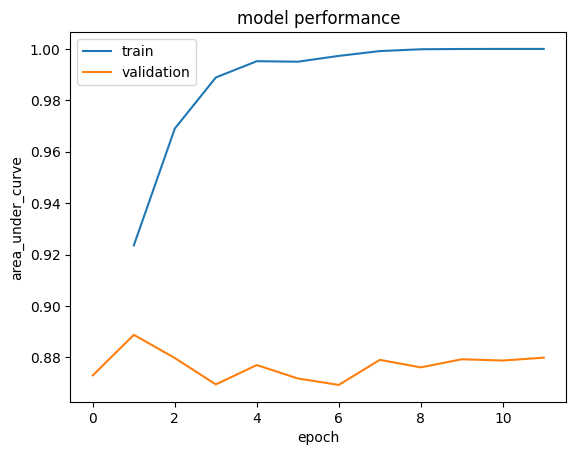

In [33]:
plot_hist(hist, metric='f1_score')

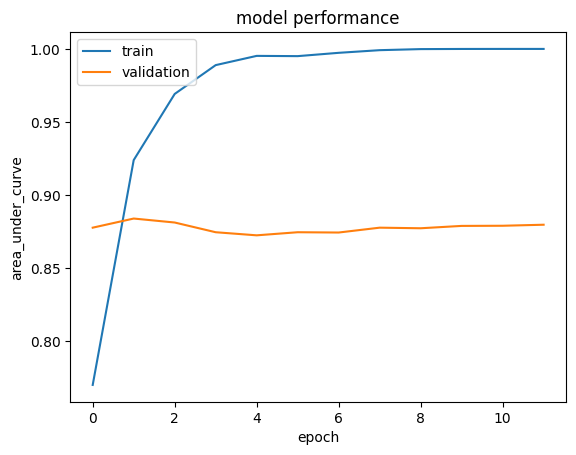

In [34]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [39]:
def create_CNN1D_tune(embedding_dim, configuration_index, dropout, lr, number_of_cnn1d_layers, cnn1d_filters, cnn1d_kernel_size, strides):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    for _ in range(number_of_cnn1d_layers):
        model.add(Conv1D(cnn1d_filters, cnn1d_kernel_size, padding="valid", activation="relu", strides= strides))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC(name="auc")]
    )
    return model

def tune_CNN1D(hp):
    vectorize_layer_ind = hp.Choice("vectorize config", values=[0, 1, 2, 3])
    dropout = hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    number_of_cnn1d_layers = hp.Int("number of cnn1d layers", min_value=1, max_value=3, step=1)
    cnn1d_filters = hp.Choice("cnn1d filters", values=[64, 128, 256])
    cnn1d_kernel_size = hp.Int("cnn1d kernel size", min_value=3, max_value=7, step=2)
    strides = hp.Int("strides", min_value=1, max_value=3, step=1)
    
    model = create_CNN1D_tune(
        embedding_dim=embedding_dim, configuration_index=vectorize_layer_ind, dropout=dropout, lr=lr, 
        number_of_cnn1d_layers=number_of_cnn1d_layers, cnn1d_filters=cnn1d_filters, cnn1d_kernel_size=cnn1d_kernel_size, strides=strides
    )
    return model

In [40]:
tuner_CNN1D = keras_tuner.RandomSearch(
    hypermodel=tune_CNN1D,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="cnn1d",
)

tuner_CNN1D.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

print(tuner_CNN1D.get_best_models()[0].summary())
#  get best hyperparameters
best_hps=tuner_CNN1D.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from ./working\cnn1d\tuner0.json


INFO:tensorflow:Reloading Tuner from ./working\cnn1d\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 160)          3200160   
                                                                 
 conv1d (Conv1D)             (None, 247, 128)          143488    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0

None


#### Build Tuned Model

In [41]:
## Training the best model
best_CNN1D = tuner_CNN1D.get_best_models()[0]
best_CNN1D.build(X_train.shape)
hist = best_CNN1D.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

Epoch 1/10
1240/1240 [==============================] - 79s 63ms/step - loss: 0.1734 - accuracy: 0.9350 - f1_score: 0.9335 - auc: 0.9811 - val_loss: 0.3686 - val_accuracy: 0.8867 - val_f1_score: 0.8904 - val_auc: 0.9552 - lr: 0.0041
Epoch 2/10
1240/1240 [==============================] - 73s 59ms/step - loss: 0.0724 - accuracy: 0.9753 - f1_score: 0.9747 - auc: 0.9959 - val_loss: 0.4450 - val_accuracy: 0.8861 - val_f1_score: 0.8870 - val_auc: 0.9445 - lr: 0.0041
Epoch 3/10
1240/1240 [==============================] - 73s 59ms/step - loss: 0.0476 - accuracy: 0.9835 - f1_score: 0.9828 - auc: 0.9980 - val_loss: 0.3955 - val_accuracy: 0.8836 - val_f1_score: 0.8764 - val_auc: 0.9483 - lr: 0.0041
Epoch 4/10
1240/1240 [==============================] - 73s 59ms/step - loss: 0.0316 - accuracy: 0.9896 - f1_score: 0.9893 - auc: 0.9989 - val_loss: 0.6433 - val_accuracy: 0.8692 - val_f1_score: 0.8750 - val_auc: 0.9318 - lr: 0.0041
Epoch 5/10
1240/1240 [==============================] - 74s 60ms/ste

##### Tuned Model Testing

In [42]:
# Classification Report and Confusion Matrix
y_pred = best_CNN1D.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

310/310 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4939
           1       0.88      0.89      0.89      4977

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



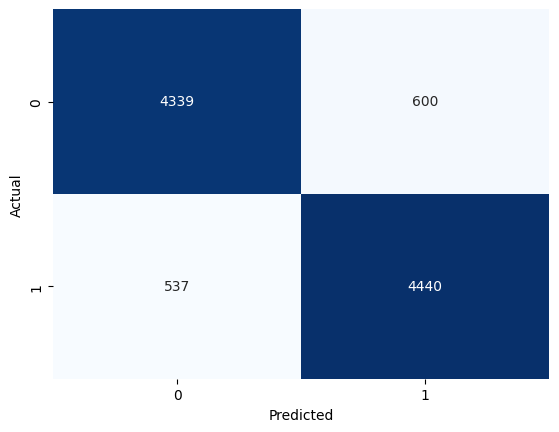

In [43]:
plot_confusion_matrix(y_test, y_pred)

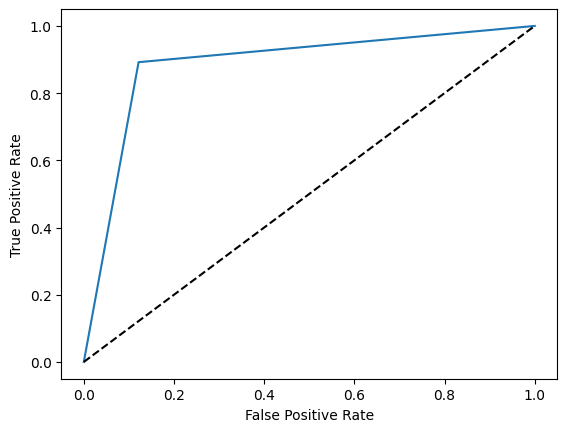

In [44]:
plot_roc_auc(y_test, y_pred)

##### Tuned Model History

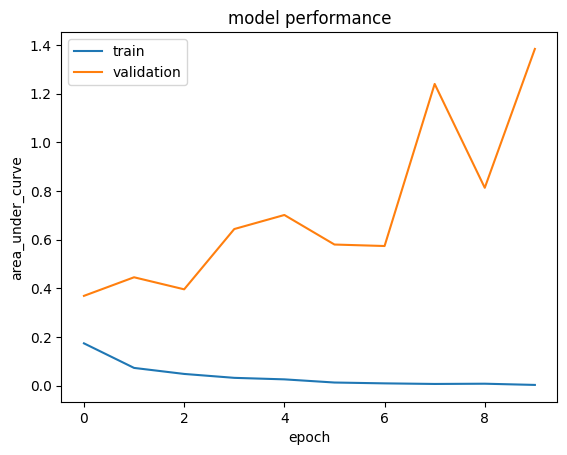

In [45]:
plot_hist(hist, metric='loss')

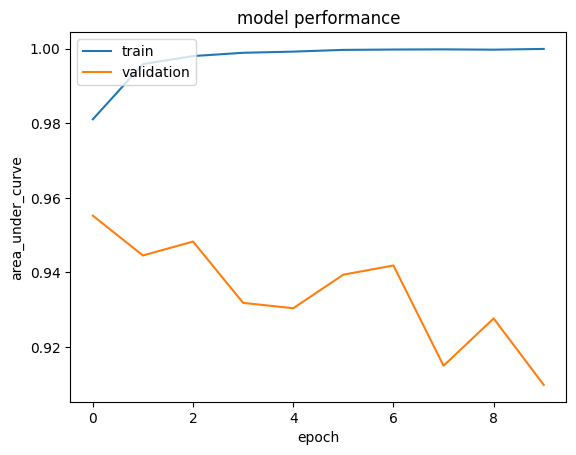

In [46]:
plot_hist(hist)

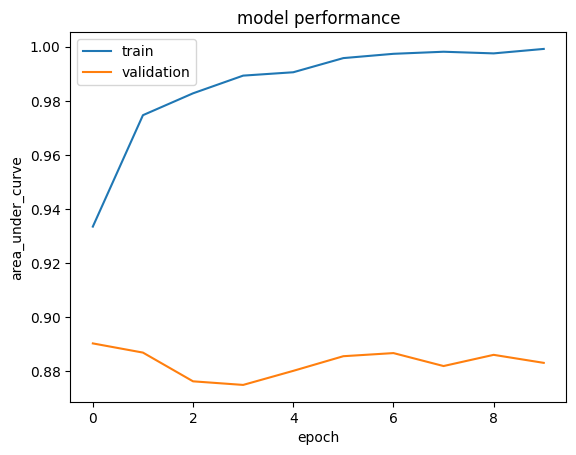

In [47]:
plot_hist(hist, metric='f1_score')

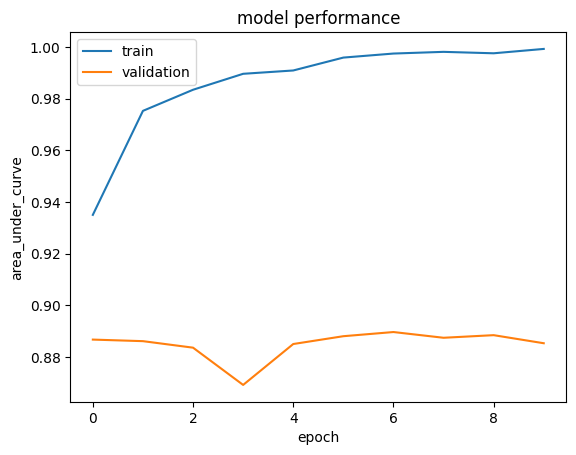

In [48]:
plot_hist(hist, metric='accuracy')

In [50]:
#  save model 
best_CNN1D.save("./models/best_cnn1d_model")

INFO:tensorflow:Assets written to: ./models/best_cnn1d_model\assets


INFO:tensorflow:Assets written to: ./models/best_cnn1d_model\assets


## RNN

## GRU